In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from keras.models import load_model

import math

Using TensorFlow backend.


In [190]:
WIDTH = 64
HEIGHT = 64
DIM = (WIDTH,HEIGHT)

Lets load the model that we train using EMNIST dataset.

In [60]:
model = load_model('../data/ocr_model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 32)        25632     
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 32)       

In [ ]:
order = '0123456789abcdefghijklmnopqrstuvwxyz'
def predict(img):
    img = img.reshape(1,WIDTH,HEIGHT,1)
    pred = model.predict(img)
    
    return order[np.argmax(pred)]
    

In [3]:
ori_img = cv2.imread('../data/geran_kereta.jpg')
img = ori_img[110:122,283:310] #crop to get just the number aka ROI
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(img,5)


In [4]:
def showImg(image, t='image'):
    cv2.imshow(t, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

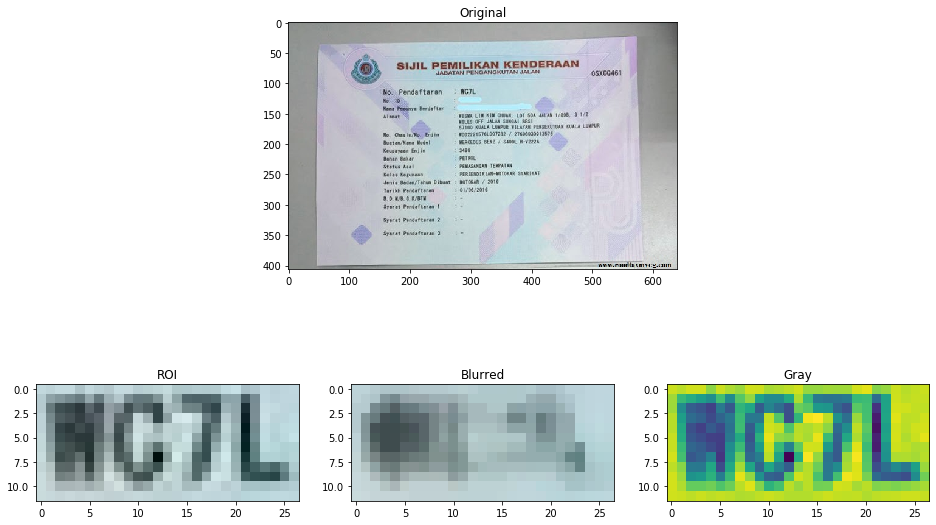

In [57]:
plt.figure(figsize=(16,10))

plt.subplot(2,1,1)
plt.title('Original')
plt.imshow(ori_img)

plt.subplot(2,3,4)
plt.title('ROI')
plt.imshow(img)

plt.subplot(2,3,5)
plt.title('Blurred')
plt.imshow(blurred)

plt.subplot(2,3,6)
plt.title('Gray')
plt.imshow(gray)

plt.show()

That is some nasty image quality I would say, but let see what we can do.

Note: The gray img is not show in gray because it is interpreted by matplotlib, you can see it in gray with cv2.imshow()

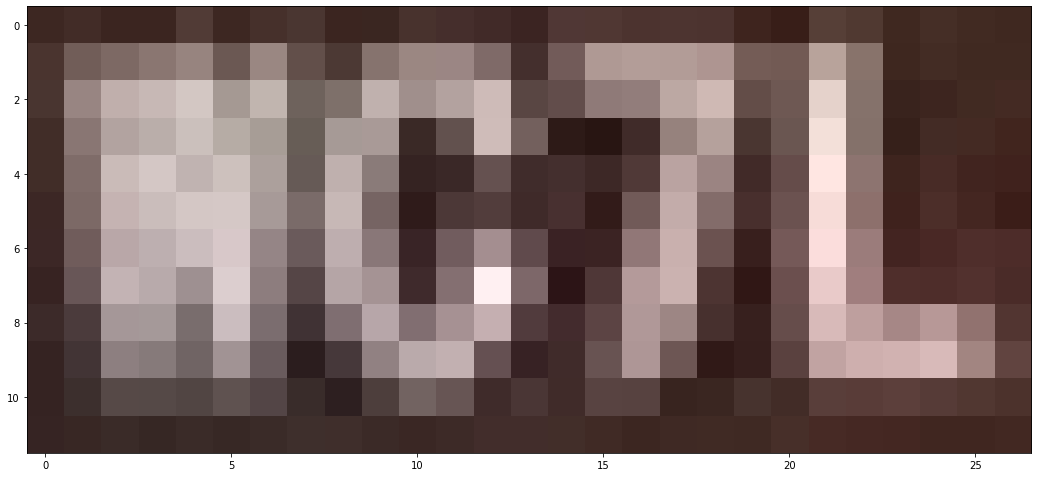

In [58]:
plt.figure(figsize=(18,20))
plt.imshow( 255-img)

In [61]:
ret, thresh = cv2.threshold(gray, 127,255,cv2.THRESH_BINARY_INV)

showImg(thresh)

In [62]:
adaptive_threshold = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                           cv2.THRESH_BINARY, 11, 10)
showImg(adaptive_threshold)

Usually adaptive threshold will convert image to black and white better, but due to this kind of image quality the changes seems not having much different.

In [188]:
def cropImg(mask, img):
    # Getting the edges
    (y, x) = np.where(mask == 255)
    #Find the highst and lowest edges
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))    
    #Now we know the area, then we crop
    img = img[topy:bottomy+1, topx:bottomx+1]
    return img

#selfmade padding functions
def padding(img):
    row = img.shape[0]
    col = img.shape[1]
    
    if row == col:
        return img
    
    if row > col:
        pad_range = (row - col) / 2
        left = math.floor(pad_range)
        right = math.ceil(pad_range)
        padded_img = np.append(img, np.zeros((row,right)), axis=1)
        padded_img = np.concatenate((np.zeros((row,left)), padded_img), axis=1)

    if col > row:
        pad_range = (col - row) / 2
        top = math.ceil(pad_range)
        bottom = math.floor(pad_range)
        padded_img = np.append(img, np.zeros((top,col)), axis=0)
        padded_img = np.concatenate((np.zeros((bottom,col)), padded_img), axis=0)
    
    return padded_img
    

The countours will find seperate group of edges. From each countour, we will crop based on the edges detected for us to feed it in model for letter recognition

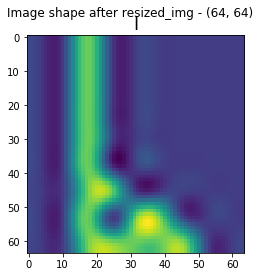

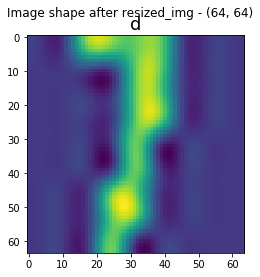

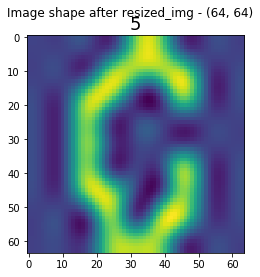

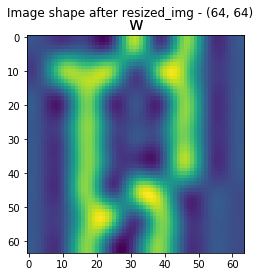

In [239]:
contours, hierarchy = cv2.findContours(adaptive_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plate_number = ''
for i,cntr in enumerate(contours):
    canvas = np.zeros(thresh.shape, dtype="uint8")
    mask = cv2.drawContours(canvas, contours, i, (255,255,255), 1)
    cropped_img = cropImg(mask, canvas)
    padded_img = padding(cropped_img)
    resized_img = cv2.resize(padded_img, DIM, interpolation = cv2.INTER_LANCZOS4)
    predicted_letter = predict(255-resized_img)
    plate_number = plate_number + predicted_letter
    plt.figure()
#     plt.title(f"Image shape after cropped - {cropped_img.shape}")
    plt.suptitle(f"Image shape after resized_img - {resized_img.shape}")
    plt.title(predicted_letter, fontsize=18)
    plt.imshow(resized_img)
#     plt.imshow(mask)
plt.show()

In [240]:
print(f" Plate number - \'{plate_number[::-1]}\'")

 Plate number - 'w5dl'
